In [2]:
import numpy as np
from pysr import PySRRegressor
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import torch 

np.random.seed(0)

### Custom loss function

In [3]:
def custom_loss(dataset_size, n_datasets):
    return f"""
    import Pkg
    Pkg.add("Optim")
    Pkg.add("DynamicExpressions")
    
    using SymbolicRegression
    using Optim
    using DynamicExpressions: 
        count_scalar_constants
    
    function multitask_loss(tree, dataset:: Dataset{{T, L}}, options)::L where {{T, L}}
        function my_eval(tree, x_, y_, params, options)
            id = 1
            buf = [tree]
    
            while !isempty(buf) 
                elem = pop!(buf)  
    
                if elem.degree == 0 && elem.constant
                    elem.val = params[id]
                    id += 1
                end
            end
            
            prediction, flag = eval_tree_array(tree, x_, options)
            if !flag
                return Inf
            end
            
            return sum((y_ .- prediction).^2) / length(y_)
        end
        
        num_params = count_scalar_constants(tree)
        
        if num_params == 0
            return L(Inf)
        end
    
        dataset_size = {dataset_size}
        n_datasets = {n_datasets}
        
        datasets = []
        for i in 1:n_datasets
            X = dataset.X[:, (i - 1) * dataset_size + 1: i * dataset_size]
            y = dataset.y[(i - 1) * dataset_size + 1: i * dataset_size]
            push!(datasets, (X, y))
        end
        
        total_loss = 0.0
        initial_params = ones(num_params)
        for subds in datasets
            half_idx = Int(floor(size(subds[1], 2) / 2))
            X_train, X_test = subds[1][:, 1:half_idx], subds[1][:, half_idx+1:end]
            y_train, y_test = subds[2][1:half_idx], subds[2][half_idx+1:end]
            
            res = Optim.optimize(p -> my_eval(tree, X_train, y_train, p, options), initial_params)
            total_loss += my_eval(tree, X_test, y_test, Optim.minimizer(res), options)
        end
        return total_loss
    end
    """

### Setup datasets

In [4]:
n_samples = 200
np.random.seed(0)

In [5]:
phis = [-0.70848686, -0.10113233,  0.17576874,  0.89716671, -0.49494444,
       -0.2814985 , -0.24128282,  0.21107632, -0.28653589,  0.06702385,
        0.56358066,  0.41077119, -0.10726271,  0.72843236,  0.1162805 ]
psis = [ 0.37193547, -0.96524042, -0.35373869,  0.9461955 ,  0.16022446,
       -0.49155084,  0.04346009, -0.31469302,  0.06448998, -0.74851698,
       -0.73457069, -0.71291528,  0.87963958,  0.46579784, -0.67523621]
sigmas = [0.029551037, 0.04186778 , 0.10060954, 0.44087536, 0.32683888,
       0.16697152, 0.07718524, 0.15142633, 0.34071255, 0.10495392,
       0.18188845, 0.36643867, 0.49333694, 0.25242776, 0.4095183 ]
len(phis)

15

In [6]:
# Train datasets
datasets = []
for phi, sigma in zip(phis, sigmas):
    y = np.zeros(n_samples + 1)
    y[:1] = np.random.randn(1)

    for t in range(1, n_samples + 1):
        y[t] = phi * y[t-1] + np.random.normal(0, sigma)

    X = np.column_stack([y[0:n_samples]])
    y_target = y[1:n_samples + 1]

    datasets.append((X, y_target))

In [7]:
X_all = np.vstack([pair[0] for pair in datasets])
y_all = np.hstack([pair[1] for pair in datasets])

In [8]:
# Test dataset
test_series = np.zeros(n_samples + 1)
test_series[:1] = np.random.randn(1)

for t in range(1, n_samples + 1):
    test_series[t] = 0.35 * test_series[t-1] + np.random.normal(0, 0.1)

X_test = np.column_stack([test_series[0:n_samples]])
y_test = test_series[1:n_samples + 1]

# Experiments

In [9]:
options = dict(
    unary_operators=["sin", "cos", "exp", "log", "square"],
    binary_operators=["+", "*", "-", "/"],
    model_selection="best",
    verbosity=1,
    procs=8
)

## 1 dataset

In [10]:
n_datasets = 1 #[1, 2, 5, 10, 15]
iterations = 100 #[200, 500, 1000, 1500, 2000]

X_part = X_all[:n_samples * n_datasets, :]
y_part = y_all[:n_samples * n_datasets]

model_1ds = PySRRegressor(
    niterations=iterations,
    loss_function=custom_loss(dataset_size=n_samples, n_datasets=n_datasets),
    maxdepth=4,
    **options
)

model_1ds.fit(X_part, y_part)

Compiling Julia backend...


   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
[ Info: Started!



Expressions evaluated per second: 2.550e+03
Progress: 31 / 3100 total iterations (1.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.631e-03  1.594e+01  y = 0.00072587
3           9.079e-04  2.930e-01  y = x₀ / -1.5034
4           9.078e-04  5.204e-05  y = sin(x₀) * -0.66562
5           9.061e-04  1.906e-03  y = x₀ / (-1.6053 + x₀)
6           9.000e-04  6.814e-03  y = (x₀ * -0.65536) - square(x₀)
7           8.998e-04  1.820e-04  y = (x₀ * -0.66537) - sin(square(x₀))
13          8.997e-04  2.019e-05  y = (x₀ + (x₀ * -1.6654)) - ((x₀ * 0.56141) * (x₀ + x₀))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then 

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                      0.00090666494   
	1   >>>>  0.293023                                    x0 / -1.5033888   
	2         0.000052                               sin(x0) * -0.6656213   
	3         0.008903                            x0 * (-0.66537005 - x0)   
	4         0.001189                0.67137283 - (exp(x0) * 0.66911435)   
	5         0.023545            (6.4323717e-6 / x0) + (x0 * -0.6691957)   
	6         0.012262   (-9.214558e-10 / square(x0)) + (x0 * -0.6656507)   
	7         0.000055  (-9.214558e-10 / square(x0)) + (sin(x0) * -0.6...   
	8         0.009150  ((-0.66541016 - x0) * x0) + (-8.657822e-10 / s...   
	9         0.006621  (x0 + 0.67868495) * ((0.005961718 - x0) - (-1....   
	10        0.009361  ((x0 + -0.0037839233) * (-0.66541016 - x0)) + ...   
	11        0.008566  ((x0 / 0.333858) + 0.70641834) * ((0.010350199...   
	12        0.000001  ((x0 + 0.7069537) + (x0 + x0)) * ((0.010395632...   
	
	        loss  complexity  
	0   0.001631           1  
	1   0.000908           3  
	2   0.000908           4  
	3   0.000900           5  
	4   0.000899           6  
	5   0.000878           7  
	6   0.000867           8  
	7   0.000867           9  
	8   0.000859          10  
	9   0.000853          11  
	10  0.000846          12  
	11  0.000838          13  
	12  0.000838          15  
]

  - outputs/20250309_153847_tJR6mk/hall_of_fame.csv


In [12]:
model_1ds.sympy()

x0/(-1.5033888)

## 2 datasets

In [13]:
n_datasets = 2 #[1, 2, 5, 10, 15]
iterations = 100 #[200, 500, 1000, 1500, 2000]

X_part = X_all[:n_samples * n_datasets, :]
y_part = y_all[:n_samples * n_datasets]

model_2ds = PySRRegressor(
    niterations=iterations,
    loss_function=custom_loss(dataset_size=n_samples, n_datasets=n_datasets),
    maxdepth=4,
    **options
)

model_2ds.fit(X_part, y_part)

   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
[ Info: Started!



Expressions evaluated per second: 1.780e+04
Progress: 131 / 3100 total iterations (4.226%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.145e-03  1.594e+01  y = -0.0037595
3           2.716e-03  7.324e-02  y = x₀ * -0.37689
4           2.716e-03  1.794e-05  y = sin(x₀) * -0.37709
5           2.685e-03  1.166e-02  y = x₀ * (-0.35261 - x₀)
6           2.682e-03  1.123e-03  y = (-0.3725 * x₀) - square(x₀)
7           2.669e-03  4.867e-03  y = ((x₀ / -0.23559) * 0.090906) + -0.0048903
8           2.668e-03  1.841e-04  y = (-0.012551 - x₀) * (0.38995 - square(x₀))
12          2.659e-03  8.234e-04  y = ((x₀ * 0.033663) - square(x₀)) + ((-0.0077525 - x₀) / ...
                                      2.3477)
14          2.659e-03  2.980e-08  y = ((x₀ * 1.6077) - square(x₀)) + ((0.73665 

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                      -0.0037367132   
	1   >>>>  0.073244                                    x0 * -0.3768929   
	2         0.000018                              sin(x0) * -0.37708825   
	3         0.017649                    (x0 * -0.3859061) - 0.004890419   
	4         0.001135               (exp(x0) * -0.3879802) - -0.38339454   
	5         0.002343          -0.0033021416 - (x0 * (x0 - -0.39227837))   
	6         0.013319    0.38555261 / ((0.0048207124 - x0) / square(x0))   
	7         0.000035  square(sin(x0)) / ((0.0048207124 - x0) / 0.384...   
	8         0.008939  (x0 + 0.3867107) / ((0.0048162644 - x0) / squa...   
	9         0.000346  square(x0 + 0.62407905) / ((0.0048147202 - x0)...   
	10        0.000371  (square(x0) * (x0 + 0.2895693)) / ((0.00481520...   
	11        0.000030  ((x0 + 0.26584777) * (1.487851 - x0)) / ((0.00...   
	
	        loss  complexity  
	0   0.003145           1  
	1   0.002716           3  
	2   0.002716           4  
	3   0.002669           5  
	4   0.002666           6  
	5   0.002659           7  
	6   0.002624           8  
	7   0.002624           9  
	8   0.002601          10  
	9   0.002600          11  
	10  0.002599          12  
	11  0.002599          14  
]

  - outputs/20250309_154209_mnkM9S/hall_of_fame.csv


In [14]:
model_2ds.sympy()

x0*(-0.3768929)

## 5 datasets

In [15]:
n_datasets = 5 #[1, 2, 5, 10, 15]
iterations = 100 #[200, 500, 1000, 1500, 2000]

X_part = X_all[:n_samples * n_datasets, :]
y_part = y_all[:n_samples * n_datasets]

model_5ds = PySRRegressor(
    niterations=iterations,
    loss_function=custom_loss(dataset_size=n_samples, n_datasets=n_datasets),
    maxdepth=4,
    **options
)

model_5ds.fit(X_part, y_part)

   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
[ Info: Started!



Expressions evaluated per second: 2.110e+03
Progress: 24 / 3100 total iterations (0.774%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.356e-01  1.594e+01  y = -0.11532
3           4.766e-01  2.170e-01  y = x₀ * 0.60493
5           4.723e-01  4.550e-03  y = (x₀ + -0.050707) * 0.59034
6           4.516e-01  4.486e-02  y = sin(x₀ + 1.0446) + -0.86014
7           4.251e-01  6.044e-02  y = (x₀ - 0.11024) * square(sin(x₀))
8           4.119e-01  3.158e-02  y = (sin(x₀) - 0.41019) * square(sin(x₀))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 7

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                  equation      loss  \
	0        0.000000                              -0.021417236  0.634582   
	1  >>>>  0.143115                            x0 * 0.6049345  0.476628   
	2        0.012101                     x0 / (x0 + 2.9542856)  0.465231   
	3        0.052141                 x0 * cos(0.57508105 / x0)  0.441595   
	4        0.038060      (x0 - 0.110242225) * square(sin(x0))  0.425104   
	5        0.037471  square(sin(x0)) * (sin(x0) - 0.31805438)  0.409470   
	
	   complexity  
	0           1  
	1           3  
	2           5  
	3           6  
	4           7  
	5           8  
]

  - outputs/20250309_154329_ZhUyv6/hall_of_fame.csv


In [16]:
model_5ds.sympy()

x0*0.6049345

## 10 datasets

In [17]:
n_datasets = 10 #[1, 2, 5, 10, 15]
iterations = 100 #[200, 500, 1000, 1500, 2000]

X_part = X_all[:n_samples * n_datasets, :]
y_part = y_all[:n_samples * n_datasets]

model_10ds = PySRRegressor(
    niterations=iterations,
    loss_function=custom_loss(dataset_size=n_samples, n_datasets=n_datasets),
    maxdepth=4,
    **options
)

model_10ds.fit(X_part, y_part)

   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
[ Info: Started!



Expressions evaluated per second: 1.600e+03
Progress: 16 / 3100 total iterations (0.516%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.402e-01  1.594e+01  y = -0.018805
3           7.632e-01  1.042e-01  y = x₀ * 0.44138
5           7.445e-01  1.240e-02  y = (x₀ * -0.44601) * x₀
6           7.087e-01  4.931e-02  y = (x₀ / exp(x₀)) * 0.17674
7           6.556e-01  7.796e-02  y = square(sin(x₀)) * (x₀ - 0.043041)
9           6.418e-01  1.060e-02  y = (x₀ * sin(x₀)) * sin(-0.32458 + x₀)
10          6.401e-01  2.605e-03  y = (sin(x₀) * sin(x₀)) * (sin(x₀) + -0.26763)
11          6.382e-01  2.992e-03  y = square(sin(x₀)) * ((x₀ - 0.16682) + (-0.18709 / x₀))
───────────────────────────────────────────────────────────────────────────────────────────────────
══════════════════════════

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                      -0.0138549805   
	1        0.042692                                     x0 * 0.4413835   
	2        0.026181                               cos(x0) + -0.9901512   
	3        0.033454                       (x0 - square(x0)) * 0.288292   
	4  >>>>  0.066386                square(sin(x0)) * (x0 * 0.87141883)   
	5        0.016411          square(sin(x0)) * (sin(x0) + -0.26767093)   
	6        0.005655    (square(x0) * 0.6981077) * sin(x0 + -0.5995374)   
	7        0.004214  (sin(x0) * (x0 - 0.5763649)) * (sin(x0) + 0.31...   
	
	       loss  complexity  
	0  0.831273           1  
	1  0.763241           3  
	2  0.743518           4  
	3  0.695399           6  
	4  0.650734           7  
	5  0.640142           8  
	6  0.636532           9  
	7  0.631190          11  
]

  - outputs/20250309_154653_1U0sVY/hall_of_fame.csv


In [18]:
model_10ds.sympy()

sin(x0)**2*x0*0.87141883

## 15 datasets

In [19]:
n_datasets = 15 #[1, 2, 5, 10, 15]
iterations = 100 #[200, 500, 1000, 1500, 2000]

X_part = X_all[:n_samples * n_datasets, :]
y_part = y_all[:n_samples * n_datasets]

model_15ds = PySRRegressor(
    niterations=iterations,
    loss_function=custom_loss(dataset_size=n_samples, n_datasets=n_datasets),
    maxdepth=4,
    **options
)

model_15ds.fit(X_part, y_part)

   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
[ Info: Started!



Expressions evaluated per second: 2.330e+02
Progress: 2 / 3100 total iterations (0.065%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
3           1.545e+00  5.314e+00  y = x₀ * 0.053428
4           1.447e+00  6.519e-02  y = square(0.40238) * x₀
6           1.310e+00  4.977e-02  y = (x₀ * 0.16191) / exp(x₀)
8           1.310e+00  9.827e-05  y = (x₀ * 0.18791) / exp(x₀ + 0.11906)
10          1.306e+00  1.638e-03  y = (square(0.40238) * (x₀ + x₀)) / exp(sin(x₀))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.040e+03
Progress: 33 / 3100 total iterations (

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       -0.021289062   
	1  >>>>  0.047254                                    x0 * 0.38731134   
	2        0.003415                     (x0 - 0.06625445) * 0.37807524   
	3        0.046439                 0.27650914 - (0.2865095 / exp(x0))   
	4        0.010095                square(sin(x0)) * (x0 * 0.81017774)   
	5        0.007646  square(sin(x0)) * ((x0 - 0.33146644) * 0.6932291)   
	
	       loss  complexity  
	0  1.501036           1  
	1  1.365674           3  
	2  1.356379           5  
	3  1.294831           6  
	4  1.281825           7  
	5  1.262371           9  
]

  - outputs/20250309_155237_5Bu2UT/hall_of_fame.csv


In [20]:
model_15ds.sympy()

x0*0.38731134

---

# Misc

In [10]:
options = dict(
    unary_operators=["sin", "cos", "exp", "log", "square"],
    binary_operators=["+", "*", "-", "/"],
    model_selection="best",
    verbosity=1,
    procs=8
)

In [11]:
# models = []
# accuracies = []
n_datasets = [15] #[1, 2, 5, 10, 15]
iterations = [100] #[200, 500, 1000, 1500, 2000]

for n_dataset, niterations in zip(n_datasets, iterations):
    X_part = X_all[:n_samples * n_dataset, :]
    y_part = y_all[:n_samples * n_dataset]

    model = PySRRegressor(
        niterations=niterations,
        loss_function=custom_loss(dataset_size=n_samples, n_datasets=n_dataset),
        maxdepth=4,
        **options
    )

    model.fit(X_part, y_part)
    print("Model: ", model.sympy().simplify())
    
    y_pred = model.predict(X_part)
    
    mse = mean_squared_error(y_part, y_pred)
    mae = mean_absolute_error(y_part, y_pred)
    r2 = r2_score(y_part, y_pred)
    # accuracies.append(accuracy)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print("------------------------------------------------")

Compiling Julia backend...


   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`



Expressions evaluated per second: 9.900e+02
Progress: 6 / 3100 total iterations (0.194%)
════════════════════════════════════════════════════════════════════════════════════════════════════


[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.769e+00  1.594e+01  y = 0.071469
3           1.366e+00  1.295e-01  y = x₀ * 0.38731
5           1.356e+00  3.415e-03  y = (x₀ * 0.37801) + -0.025078
6           1.320e+00  2.736e-02  y = log((x₀ * 0.36814) + 0.98389)
8           1.297e+00  8.733e-03  y = (x₀ - (x₀ * x₀)) * exp(-1.3192)
9           1.297e+00  6.277e-05  y = ((x₀ + -0.00071562) - (x₀ * x₀)) * 0.27164
11          1.297e+00  1.037e-04  y = ((x₀ - 1.0994) * 0.511) * ((x₀ / -1.0439) * 0.52684)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.640e+03
Progress: 54 / 3100 total iterations (1.742%)
════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:


Model:  0.38730642*x0
Mean Squared Error (MSE): 0.0988
Mean Absolute Error (MAE): 0.2093
R^2 Score: 0.1684
------------------------------------------------
  - outputs/20250306_123555_JdEeCZ/hall_of_fame.csv


In [12]:
model.sympy().simplify()

0.38730642*x0

In [13]:
torch_model = model.pytorch()
[param for param in torch_model.parameters()]

[Parameter containing:
 tensor(0.3873, requires_grad=True)]

In [27]:
sigma

0.4095183

In [38]:
y[:1] = np.random.randn(1)

for t in range(1, n_samples + 1):
    y[t] = 0.48 * y[t-1] + np.random.normal(0, 0.01)

X = np.column_stack([y[0:n_samples]])
y_target = y[1:n_samples + 1]

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y_target)
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [39]:
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [40]:
num_epochs = 30
torch_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in loader:
        outputs = torch_model(inputs).squeeze()
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(loader):.4f}')

Epoch [1/30], Loss: 0.0001
Epoch [2/30], Loss: 0.0001
Epoch [3/30], Loss: 0.0001
Epoch [4/30], Loss: 0.0001
Epoch [5/30], Loss: 0.0001
Epoch [6/30], Loss: 0.0001
Epoch [7/30], Loss: 0.0001
Epoch [8/30], Loss: 0.0001
Epoch [9/30], Loss: 0.0001
Epoch [10/30], Loss: 0.0001
Epoch [11/30], Loss: 0.0001
Epoch [12/30], Loss: 0.0001
Epoch [13/30], Loss: 0.0001
Epoch [14/30], Loss: 0.0001
Epoch [15/30], Loss: 0.0001
Epoch [16/30], Loss: 0.0001
Epoch [17/30], Loss: 0.0001
Epoch [18/30], Loss: 0.0001
Epoch [19/30], Loss: 0.0001
Epoch [20/30], Loss: 0.0001
Epoch [21/30], Loss: 0.0001
Epoch [22/30], Loss: 0.0001
Epoch [23/30], Loss: 0.0001
Epoch [24/30], Loss: 0.0001
Epoch [25/30], Loss: 0.0001
Epoch [26/30], Loss: 0.0001
Epoch [27/30], Loss: 0.0001
Epoch [28/30], Loss: 0.0001
Epoch [29/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0001


In [41]:
[param for param in torch_model.parameters()]

[Parameter containing:
 tensor(0.4395, requires_grad=True)]

In [46]:
y_pred = torch_model(X_tensor).detach().numpy()
mse = mean_squared_error(y[1:], y_pred)
mae = mean_absolute_error(y[1:], y_pred)
r2 = r2_score(y[1:], y_pred)
# accuracies.append(accuracy)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0001
Mean Absolute Error (MAE): 0.0074
R^2 Score: 0.6011


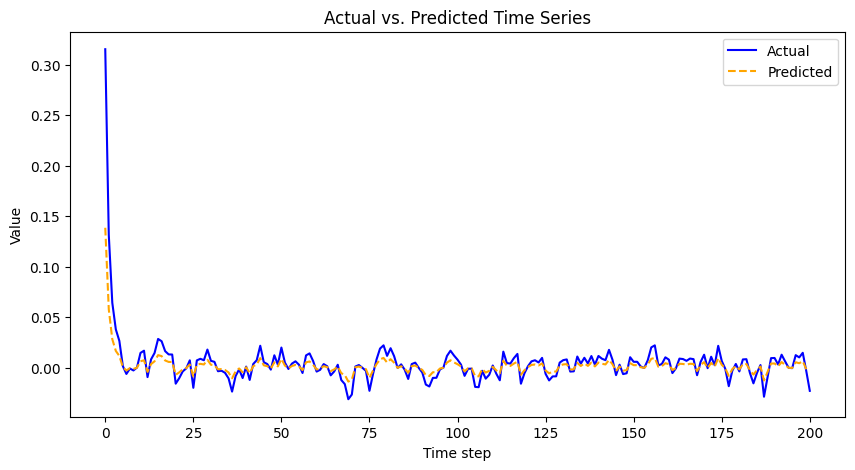

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y)), y, label="Actual", color="blue")
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted", color="orange", linestyle="--")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.title("Actual vs. Predicted Time Series")
plt.legend()
plt.show()

Можно заметить, что отличия исключительно из-за шума.